Performance evaluation in the training process.   \textbf{a} Variations of the metrics along with iterations. \textbf{b} Accuracy-PTA curve in terms of different  iterations. \textbf{c}, \textbf{d}, \textbf{e}, \textbf{f}, \textbf{g}, \textbf{h} visualize  the latent cluster feature space after 0, 50, 300, 500, 1000 and 2000 iterations by t-SNE  method,  respectively.

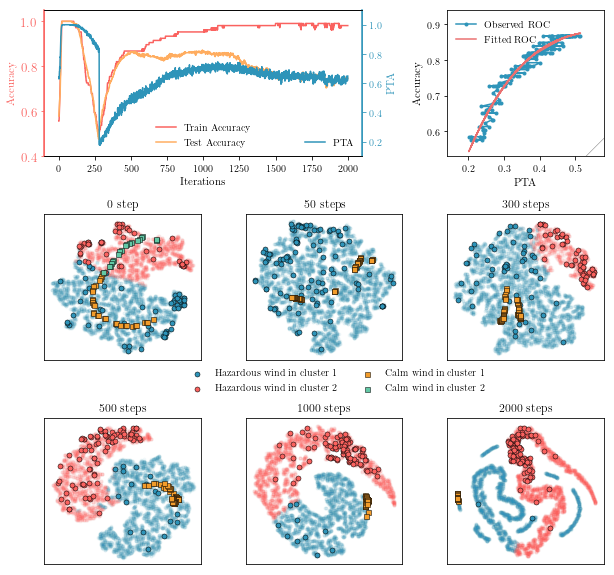

In [4]:
import scipy.io as scio
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import ConvLSTM2D, Dense, LeakyReLU, Multiply
from tensorflow.keras.layers import BatchNormalization, Lambda, Multiply, Add
from sklearn.metrics import roc_curve, auc
import numpy as np
import random
import math
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from tensorflow import keras
from sklearn.svm import SVC
from tqdm import tqdm
from tools import *
from sklearn.manifold import TSNE
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [1.6*fig_width,fig_width*1.5]
    return fig_size
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 11,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 10,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize(1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
import matplotlib as mpl
mpl.rcParams.update(pgf_with_latex)
gs = plt.GridSpec(3, 15)

ACC_XUJING = scio.loadmat('ACC_XUJING_44.mat')
ACC_XUJING = ACC_XUJING['ACC_XUJING']
ax = plt.subplot(gs[0,0:9])
p = ax.twinx() 

trainColor = "#fa625f"
ptaColor = '#2E94B9'
testColor = '#ffad60'
ax.plot(ACC_XUJING[:,0],color=trainColor,zorder=5,linewidth=1.5,label='Train Accuracy')
ax.plot(ACC_XUJING[:,2],color=testColor,zorder=5,linewidth=1.5,label='Test Accuracy')
p.plot(ACC_XUJING[:,1],color=ptaColor,zorder=5,linewidth=1.5,label='PTA')
ax.tick_params(axis='y',labelsize=13,labelcolor=trainColor,color=trainColor)
ax.set_ylabel('Accuracy',color=trainColor,fontsize=11, family='Arial')#,loc='top'
ax.set_xlabel('Iterations',fontsize=11, family='Arial')
ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color(trainColor)
p.spines['left'].set_color(trainColor)

ax.set_ylim(0.4,1.05)
p.set_ylim(0.1,1.1)
p.set_ylabel('PTA',color=ptaColor,fontsize=11, family='Arial')#,loc='top'
p.tick_params(axis='y',labelsize=10,labelcolor=ptaColor,color=ptaColor)
ax.spines['right'].set_color(ptaColor)
p.spines['right'].set_color(ptaColor)
p.spines['right'].set_linewidth(1.5)

ax.legend(frameon=False,loc='lower center')
p.legend(frameon=False,loc='lower right')

# Plot Accuracy-PTA curve 
ax = plt.subplot(gs[0,10:])
redColor = "#ea7070"
blueColor = '#2E94B9'
ACC_XUJING = scio.loadmat('ACC_XUJING_44.mat')
ACC_XUJING = ACC_XUJING['ACC_XUJING']
f1 = np.polyfit(ACC_XUJING[300:500,1], ACC_XUJING[300:500,0], 3)
p1 = np.poly1d(f1)
plt.plot([0,1],[0,1],linewidth=0.5,color='C7')
plt.plot(ACC_XUJING[300:500,1],ACC_XUJING[300:500,0],'.-',color=blueColor,zorder=5,linewidth=1.5,label='Observed ROC')
plt.plot(ACC_XUJING[300:500,1],p1(ACC_XUJING[300:500,1]),color=redColor,zorder=5,linewidth=1.5,label='Fitted ROC')

plt.xlim((0.14,0.58))
plt.ylim((0.53,0.94))
plt.ylabel('Accuracy')
plt.xlabel('PTA')
plt.legend(loc=2,frameon=False)

# Visualize the hazard feature space
flag = [ 'train_0step','train_50step','train_320step','train','train_1000step','train_2000step']#,'train_500step_encoded':#'test1', 'test10', 'test100'
titles = ['0 step','50 steps','300 steps','500 steps','1000 steps','2000 steps']
for r in range(6):
    plt.subplot(gs[ 1+r//3,r%3*5:r%3*5+5])
    all_embedded = scio.loadmat(f'all_embedded_{flag[r]}.mat')
    X_embedded = all_embedded['X_embedded']
    pilot_embedded = all_embedded['pilot_embedded']
    true_embedded = all_embedded['true_embedded']
    pred_ = all_embedded['pred_'][0]
    pilot_pred_ = all_embedded['pilot_pred_'][0]
    true_pred_ = all_embedded['true_pred_'][0]
    all_colors = ['#2E94B9',"#fa625f",'#62C8A5','#f29c2b']
    all_labels = ['All data in cluster 1','All data in cluster 2']
    pred_labels = ['Hazardous wind in cluster 1','Hazardous wind in cluster 2']
    true_labels = ['Calm wind in cluster 1','Calm wind in cluster 2']
    plt.scatter(X_embedded[pred_ == 0, 0], X_embedded[pred_ == 0, 1],marker='.',
                c=all_colors[0],alpha=0.04)#,label=all_labels[0]
    plt.scatter(X_embedded[pred_ == 1, 0], X_embedded[pred_ == 1, 1],marker='.',
                c=all_colors[1],alpha=0.04)#,label=all_labels[1]
    plt.scatter(pilot_embedded[pilot_pred_ == 0, 0], pilot_embedded[pilot_pred_ == 0, 1],
                marker='o',c=all_colors[0],label=pred_labels[0],edgecolors='k',linewidth=0.5,s=25)
    plt.scatter(pilot_embedded[pilot_pred_ == 1, 0], pilot_embedded[pilot_pred_ == 1, 1],
                marker='o',c=all_colors[1],label=pred_labels[1],edgecolors='k',linewidth=0.5,s=25)
    plt.scatter(true_embedded[true_pred_ == 0, 0], true_embedded[true_pred_ == 0, 1],
                    marker='s',c=all_colors[3],label=true_labels[0],alpha=1,edgecolors='k',linewidth=0.5,s=25)#0.2,0.5

    plt.scatter(true_embedded[true_pred_ == 1, 0], true_embedded[true_pred_ == 1, 1],
                    marker='s',c=all_colors[2],label=true_labels[1],alpha=1,edgecolors='k',linewidth=0.5,s=25)

    plt.xticks(())
    plt.yticks(())
    plt.title(titles[r])
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.3, 1.4), frameon=False,ncol=2)
plt.show()